# 鐵達尼號生還預測：羅吉斯迴歸模型

## 1. 環境準備
導入所需的套件，並從我們建立的 `data_preprocessing.py` 腳本中導入資料準備函式。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# 設定中文字體和圖表樣式
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

In [3]:
def prepare_data_for_modeling(
    cleaned_data_path, 
    features_to_drop, 
    target_column, 
    test_size=0.2, 
    random_state=42):
    """
    從清理後的數據載入資料，進行特徵編碼和資料分割，為模型訓練做準備。

    Args:
        cleaned_data_path (str): train_cleaned.csv 檔案的路徑。
        features_to_drop (list): 需要從特徵集中移除的欄位列表。
        target_column (str): 目標變數的欄位名稱。
        test_size (float): 分割給測試集的資料比例。
        random_state (int): 亂數種子，確保每次分割結果一致。

    Returns:
        tuple: 回傳 (X_train, X_test, y_train, y_test)
        X_train 訓練用的特徵
        X_test  測試用的特徵
        y_train 訓練用的答案
        y_test  測試用的答案


    """
    # 載入清理後的資料
    df = pd.read_csv(cleaned_data_path)

    # --- 特徵編碼 ---
    # 對指定的類別欄位進行 One-Hot Encoding
    # drop_first=True 可以避免共線性問題
    categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Age_Group']
    df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    ## df, 須處裡的 dataframe
    ## columns=categorical_features, 須處裡的欄位
    ## drop_first=True, 為了避免「共線性」（dummy variable trap），我們會捨棄每個特徵轉換後的第一個類別欄位。例如，如果Sex有'female'和'male' 兩類，get_dummies 只會產生 Sex_male 這一欄，因為當Sex_male 為 0 時，就隱含了該乘客是 'female'。
    
    # --- 定義特徵(X)與目標(y) ---
    # 定義目標變數 y [（'Survived'）- 是否生還]
    y = df_encoded[target_column]

    # 從編碼後的 df 中移除目標變數和指定的其他欄位，得到特徵集 X
    X = df_encoded.drop(columns=[target_column] + features_to_drop, axis=1)
    
    # 確保所有特徵都是數值型態
    X = X.apply(pd.to_numeric)

    # --- 資料分割 ---
    # 將資料分割為訓練集與測試集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test


## 2. 資料準備
呼叫 `prepare_data_for_modeling` 函式來載入資料、進行特徵編碼和分割，為模型訓練做好準備。

In [4]:
# 定義清理後資料檔案的路徑和目標欄位
# 相對於 Notebook 的路徑: projects/01_Exploratory_Data_Analysis/001_EDA_Project_A_Titanic_Survival_Analysis/data/train_cleaned.csv
cleaned_data_path = '../data/train_cleaned.csv'
target_column = 'Survived'

# 這些是不具預測性的 ID 或已被轉換/合併的原始欄位
features_to_drop = ['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Fare', 'Age']

# 執行資料準備函式
X_train, X_test, y_train, y_test = prepare_data_for_modeling(
    cleaned_data_path,
    features_to_drop=features_to_drop,
    target_column=target_column
)

print("資料準備完成！")
print(f"訓練集特徵數量: {X_train.shape[1]}")
print(f"訓練集樣本數: {X_train.shape[0]}")
print(f"測試集樣本數: {X_test.shape[0]}")

資料準備完成！
訓練集特徵數量: 16
訓練集樣本數: 712
測試集樣本數: 179


## 3. 模型訓練與評估

In [5]:
# 初始化羅吉斯迴歸模型
# max_iter 增加迭代次數以確保收斂，random_state 確保結果可重現
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 使用訓練集進行模型訓練
log_reg.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = log_reg.predict(X_test)

print("模型訓練與預測完成！")

模型訓練與預測完成！


In [6]:
# 評估模型效能
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"模型準確率 (Accuracy): {accuracy:.4f}")
print("混淆矩陣 (Confusion Matrix):")
print(conf_matrix)
print("分類報告 (Classification Report):")
print(class_report)

模型準確率 (Accuracy): 0.8380
混淆矩陣 (Confusion Matrix):
[[99 11]
 [18 51]]
分類報告 (Classification Report):
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



## 4. ROC曲線分析
ROC曲線（Receiver Operating Characteristic Curve）是評估二元分類模型效能的重要工具。

In [7]:
# 獲取預測機率（正類別的機率）
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# 計算ROC曲線的數據點
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 計算AUC值
roc_auc = auc(fpr, tpr)

print(f"AUC值: {roc_auc:.4f}")

AUC值: 0.8552


C:\Users\jedi8\AppData\Local\Temp\ipykernel_9772\1232861211.py:26: UserWarning: Glyph 20605 (\N{CJK UNIFIED IDEOGRAPH-507D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_9772\1232861211.py:26: UserWarning: Glyph 38525 (\N{CJK UNIFIED IDEOGRAPH-967D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_9772\1232861211.py:26: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_9772\1232861211.py:26: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_9772\1232861211.py:26: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_9772\1232861211.py:26: UserWarning: Glyph 32645 (\N{CJK UNIFIED IDEOGRAPH-7F85}) missi

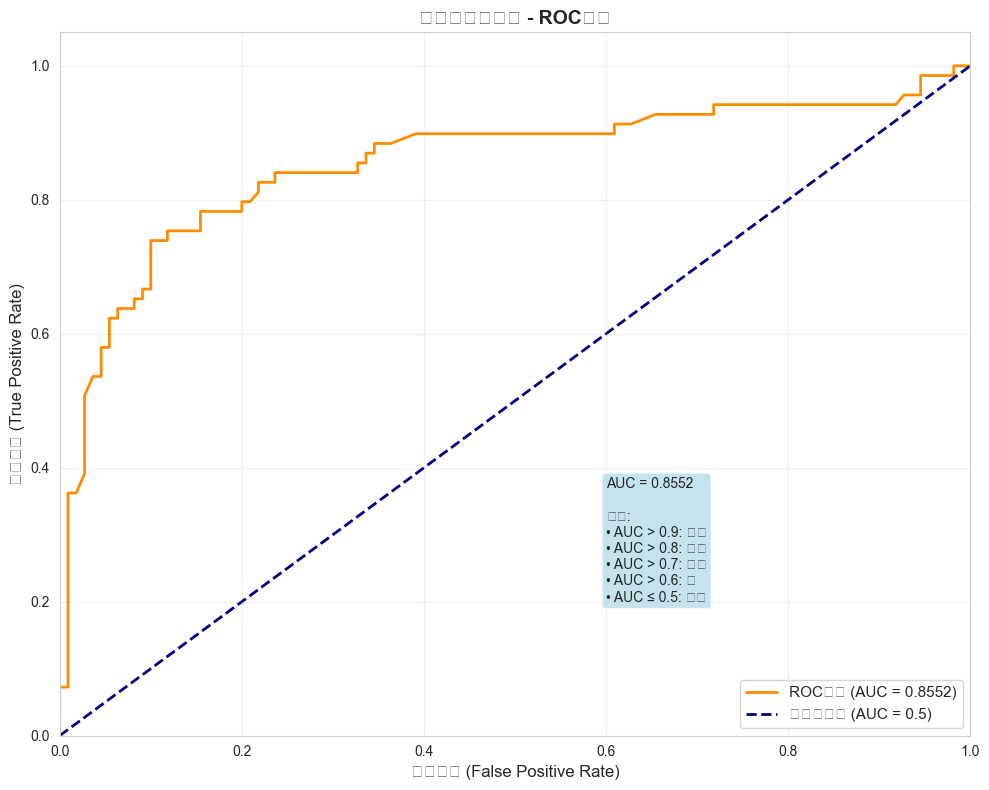

In [8]:
# 繪製ROC曲線
plt.figure(figsize=(10, 8))

# 繪製ROC曲線
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC曲線 (AUC = {roc_auc:.4f})')

# 繪製對角線（隨機分類器的基準線）
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='隨機分類器 (AUC = 0.5)')

# 設定圖表屬性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('偽陽性率 (False Positive Rate)', fontsize=12)
plt.ylabel('真陽性率 (True Positive Rate)', fontsize=12)
plt.title('羅吉斯迴歸模型 - ROC曲線', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# 添加AUC值的文字說明
plt.text(0.6, 0.2, f'AUC = {roc_auc:.4f}\n\n解釋:\n• AUC > 0.9: 優秀\n• AUC > 0.8: 良好\n• AUC > 0.7: 尚可\n• AUC > 0.6: 差\n• AUC ≤ 0.5: 無效', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
         fontsize=10)

plt.tight_layout()
plt.show()

## 5. 詳細的ROC分析

c:\Users\jedi8\anaconda3\envs\AnalysisProject\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20605 (\N{CJK UNIFIED IDEOGRAPH-507D}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jedi8\anaconda3\envs\AnalysisProject\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 38525 (\N{CJK UNIFIED IDEOGRAPH-967D}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jedi8\anaconda3\envs\AnalysisProject\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jedi8\anaconda3\envs\AnalysisProject\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jedi8\anaconda3\envs\AnalysisProject\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jedi8\anaconda3\envs\AnalysisProject

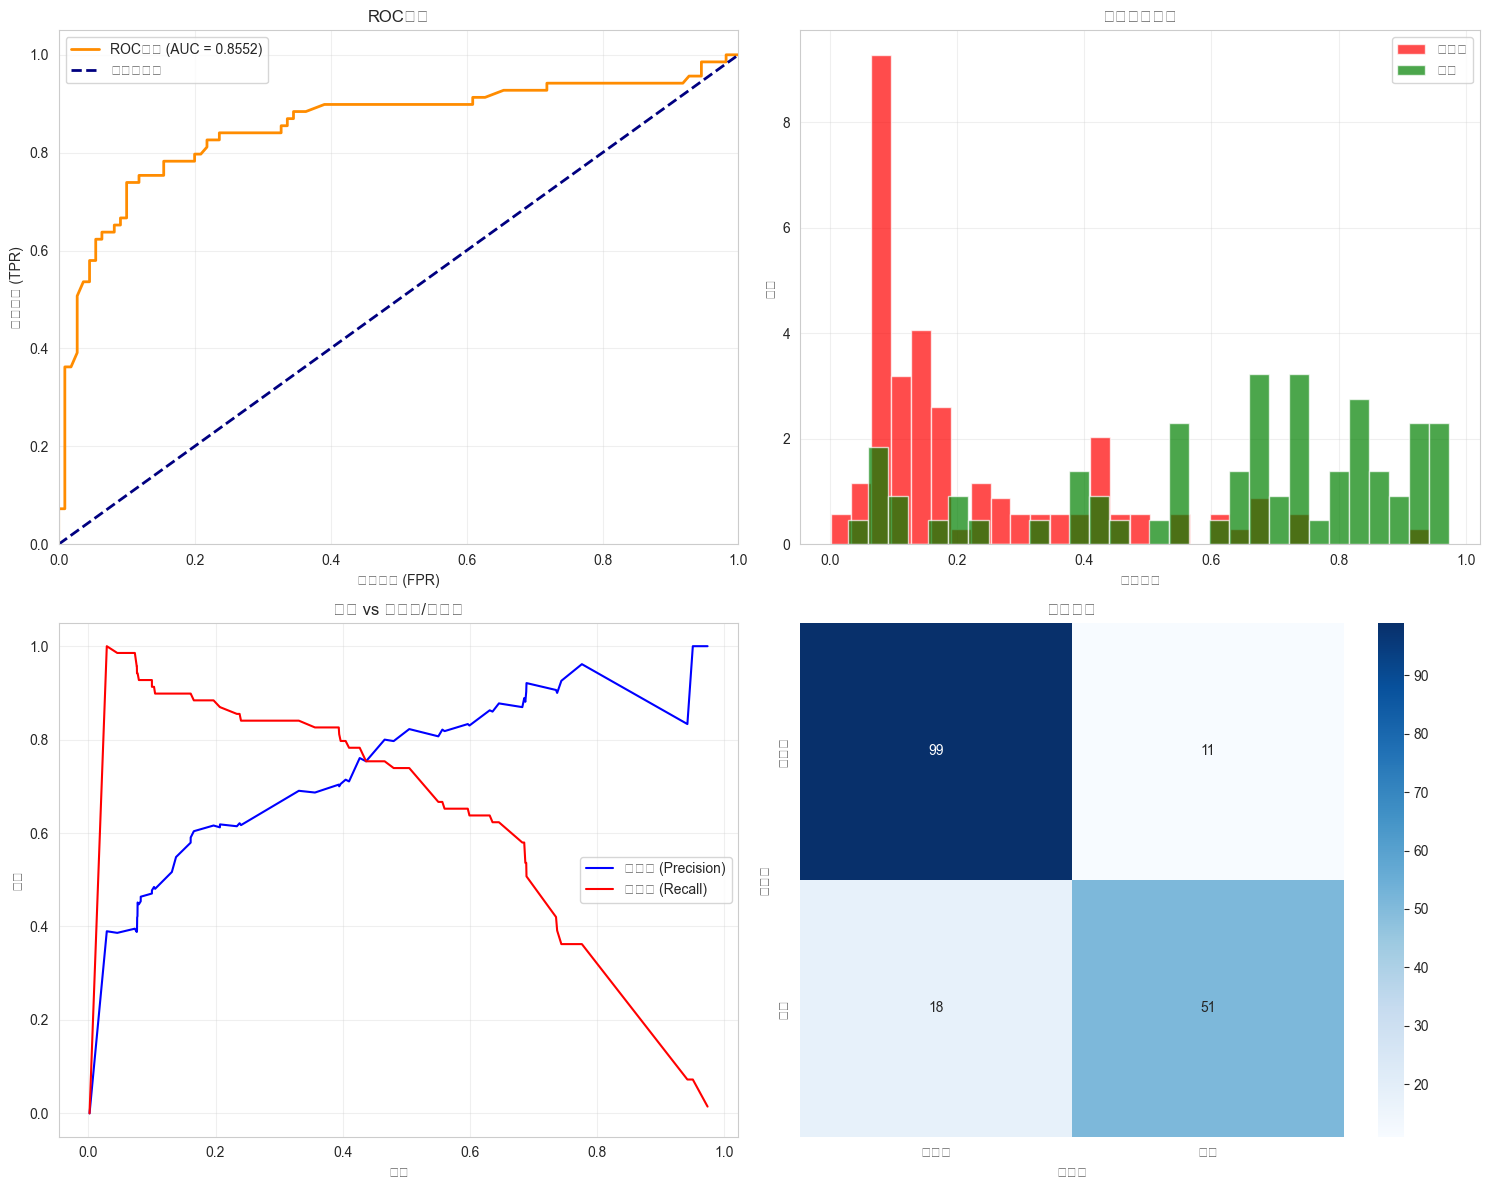

In [9]:
# 創建更詳細的ROC分析圖表
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC曲線
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC曲線 (AUC = {roc_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='隨機分類器')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('偽陽性率 (FPR)')
axes[0, 0].set_ylabel('真陽性率 (TPR)')
axes[0, 0].set_title('ROC曲線')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 預測機率分布
survived_proba = y_pred_proba[y_test == 1]
not_survived_proba = y_pred_proba[y_test == 0]

axes[0, 1].hist(not_survived_proba, bins=30, alpha=0.7, label='未生還', color='red', density=True)
axes[0, 1].hist(survived_proba, bins=30, alpha=0.7, label='生還', color='green', density=True)
axes[0, 1].set_xlabel('預測機率')
axes[0, 1].set_ylabel('密度')
axes[0, 1].set_title('預測機率分布')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 閾值 vs 精確率/召回率
from sklearn.metrics import precision_recall_curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# 為了與ROC的閾值對應，我們需要計算每個閾值下的精確率和召回率
precisions = []
recalls = []
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    if len(np.unique(y_pred_threshold)) > 1:  # 避免除零錯誤
        from sklearn.metrics import precision_score, recall_score
        prec = precision_score(y_test, y_pred_threshold, zero_division=0)
        rec = recall_score(y_test, y_pred_threshold, zero_division=0)
    else:
        prec = 0
        rec = 0
    precisions.append(prec)
    recalls.append(rec)

axes[1, 0].plot(thresholds, precisions, label='精確率 (Precision)', color='blue')
axes[1, 0].plot(thresholds, recalls, label='召回率 (Recall)', color='red')
axes[1, 0].set_xlabel('閾值')
axes[1, 0].set_ylabel('分數')
axes[1, 0].set_title('閾值 vs 精確率/召回率')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 混淆矩陣熱力圖
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['未生還', '生還'], 
            yticklabels=['未生還', '生還'],
            ax=axes[1, 1])
axes[1, 1].set_title('混淆矩陣')
axes[1, 1].set_xlabel('預測值')
axes[1, 1].set_ylabel('實際值')

plt.tight_layout()
plt.show()

## 6. ROC曲線解釋與模型效能總結

In [10]:
# 計算其他重要指標
from sklearn.metrics import f1_score, precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=" * 50)
print("羅吉斯迴歸模型效能總結")
print("=" * 50)
print(f"準確率 (Accuracy):    {accuracy:.4f}")
print(f"精確率 (Precision):   {precision:.4f}")
print(f"召回率 (Recall):      {recall:.4f}")
print(f"F1分數 (F1-Score):    {f1:.4f}")
print(f"AUC值:               {roc_auc:.4f}")
print("=" * 50)

# ROC曲線解釋
print("\nROC曲線分析:")
print(f"• AUC值為 {roc_auc:.4f}，", end="")
if roc_auc > 0.9:
    print("模型效能優秀")
elif roc_auc > 0.8:
    print("模型效能良好")
elif roc_auc > 0.7:
    print("模型效能尚可")
elif roc_auc > 0.6:
    print("模型效能較差")
else:
    print("模型幾乎無預測能力")

print(f"• 模型在區分生還與未生還乘客方面有 {(roc_auc-0.5)*200:.1f}% 的改善（相較於隨機猜測）")

# 找到最佳閾值（Youden's J statistic）
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"• 建議的最佳分類閾值: {optimal_threshold:.4f}")
print(f"  在此閾值下，TPR = {tpr[optimal_idx]:.4f}, FPR = {fpr[optimal_idx]:.4f}")

羅吉斯迴歸模型效能總結
準確率 (Accuracy):    0.8380
精確率 (Precision):   0.8226
召回率 (Recall):      0.7391
F1分數 (F1-Score):    0.7786
AUC值:               0.8552

ROC曲線分析:
• AUC值為 0.8552，模型效能良好
• 模型在區分生還與未生還乘客方面有 71.0% 的改善（相較於隨機猜測）
• 建議的最佳分類閾值: 0.5047
  在此閾值下，TPR = 0.7391, FPR = 0.1000
